This code is EXTREMELY SLOW and meant to showcase the underlying logics behind the different interpolation methods. We do not expect you to code these by hand, but you need to understand how the different interpolation methods work and potential downsides from using them!

In [1]:
import numpy as np
import scipy.io as io
from matplotlib import pyplot as plt
import time

In [2]:
def nearest_neighbor(im, zoom_factor):
	'''Zooms an image by a given factor and interpolates using the nearest neighbor interpolation method.

	Arguments:
		- im (numpy array) : input image.
		- zoom_factor (float) : magnitude of the zoom being applied to the image.

	Outputs:
		- (numpy array) : zoomed image.
	'''
	print("Peforming nearest neighbor interpolation...")

	## Create meshgrids of the original image coordinates
	x,y = np.arange(im.shape[0]), np.arange(im.shape[1])
	oldX,oldY = np.meshgrid(x,y)
	old_coords = np.stack([oldX,oldY], axis=2)

	## Apply the zoom factor to generate the zoomed image coordinates.
	zoomed_coords = old_coords*zoom_factor

	## Initialize the zoomed image as an empty array
	zoomed_h = np.rint(im.shape[0]*zoom_factor).astype(int)
	zoomed_w = np.rint(im.shape[1]*zoom_factor).astype(int)
	zoomed_im = np.zeros((zoomed_h, zoomed_w))

	## Populate the zoomed image
	for xx in range(zoomed_h):
		for yy in range(zoomed_w):
			print(f"Progress: ({xx:3d},{yy:3d}) out of {(zoomed_h-1,zoomed_w-1)}", end="\r")

			## Define a vector representing the current coordinate
			vec = np.array([xx,yy])

			## Compute the distance between the current coordinate and all other zoomed coordinates
			dist = np.linalg.norm(zoomed_coords - vec, axis=2)

			## Find the coordinate with the smallest distance to the current corodinate and
			#  assign its intensity value.
			min_index = np.argmin(dist)
			min_y,min_x = np.unravel_index(min_index, shape=im.shape)
			zoomed_im[xx,yy] = im[min_x, min_y]
	
	print()
	return zoomed_im

In [3]:

def bilinear(im, zoom_factor):
	'''Zooms an image by a given factor and interpolates using the bilinear interpolation method.

	Arguments:
		- im (numpy array) : input image.
		- zoom_factor (float) : magnitude of the zoom being applied to the image.

	Outputs:
		- (numpy array) : zoomed image.
	'''
	print("Performing bilinear interpolation...")

	## Create meshgrids of the original image coordinates
	x,y = np.arange(im.shape[0]), np.arange(im.shape[1])
	oldX,oldY = np.meshgrid(x,y)
	old_coords = np.stack([oldX,oldY], axis=2)

	## Apply the zoom factor to generate the zoomed image coordinates.
	zoomed_coords = old_coords*zoom_factor

	## Initialize the zoomed image as an empty array
	zoomed_h = np.rint(im.shape[0]*zoom_factor).astype(int)
	zoomed_w = np.rint(im.shape[1]*zoom_factor).astype(int)
	zoomed_im = np.zeros((zoomed_h, zoomed_w))

	## Populate the zoomed image
	for xx in range(zoomed_h):
		for yy in range(zoomed_w):
			print(f"Progress: ({xx:3d},{yy:3d}) out of {(zoomed_h-1,zoomed_w-1)}", end="\t")
			## Define a vector representing the current coordinate.
			vec = np.array([xx,yy])

			## Compute the distance between the current coordinate and all other zoomed coordinates.
			dist = np.linalg.norm(zoomed_coords - vec, axis=2)

			## Select the 4 coordinates with the smallest distance
			min_indices = dist.ravel().argsort()[:4]
			min_y,min_x = np.unravel_index(min_indices, shape=im.shape)
			
			## Perform bilinear interpolation by solving the matrix equation Av = b.
			# Define design matrix A using original scaled coordinates.
			x_test = min_x*zoom_factor
			y_test = min_y*zoom_factor
			A = np.array([[1, x_test[0], y_test[0], x_test[0]*y_test[0]],
						  [1, x_test[1], y_test[1], x_test[1]*y_test[1]],
						  [1, x_test[2], y_test[2], x_test[2]*y_test[2]],
						  [1, x_test[3], y_test[3], x_test[3]*y_test[3]]])
			print(f"rank(A)={np.linalg.matrix_rank(A)}", end="\r")

			# Define the intensity vector b using the pixel values from the original image.
			b = im[min_x,min_y]

			# Compute the bilinear equation parameters using the inverse of A.
			v = np.linalg.pinv(A) @ b

			## Apply the bilinear parameters to determine the final interpolated parameters.
			I = v[0] + v[1]*xx + v[2]*yy + v[3]*xx*yy
			zoomed_im[xx,yy] = I

	print()
	return zoomed_im

In [4]:
def bicubic(im, zoom_factor):
	'''Zooms an image by a given factor and interpolates using the bilinear interpolation method.

	Arguments:
		- im (numpy array) : input image.
		- zoom_factor (float) : magnitude of the zoom being applied to the image.

	Outputs:
		- (numpy array) : zoomed image.
	'''
	print("Performing bicubic interpolation...")

	## Bicubic interpolation requires at least 16 points.
	if im.size < 16:
		print("Image must have shape of at least (4,4). Padding image to minimum size.")
		im = np.pad(im, ( max(0,4-im.shape[0]), max(0,4-im.shape[1]) ))
	
	## Create meshgrids of the original image coordinates
	x,y = np.arange(im.shape[0]), np.arange(im.shape[1])
	oldX,oldY = np.meshgrid(x,y)
	old_coords = np.stack([oldX,oldY], axis=2)

	## Apply the zoom factor to generate the zoomed image coordinates.
	zoomed_coords = old_coords*zoom_factor

	## Initialize the zoomed image as an empty array
	zoomed_h = np.rint(im.shape[0]*zoom_factor).astype(int)
	zoomed_w = np.rint(im.shape[1]*zoom_factor).astype(int)
	zoomed_im = np.zeros((zoomed_h, zoomed_w))

	
	## Populate the zoomed image
	for xx in range(zoomed_h):
		for yy in range(zoomed_w):
			print(f"Progress: ({xx:3d},{yy:3d}) out of {(zoomed_h-1,zoomed_w-1)}", end="\t")

			## Define a vector representing the current coordinate.
			vec = np.array([xx,yy])

			## Compute the distance between the current coordinate and all other zoomed coordinates.
			dist = np.linalg.norm(zoomed_coords - vec, axis=2)

			## Select the 16 coordinates with the smallest distance
			min_indices = dist.ravel().argsort()[:16]
			min_y,min_x = np.unravel_index(min_indices, shape=im.shape)
			
			## Perform bicubic interpolation by solving the matrix equation Av = b.
			# Define design matrix A using original scaled coordinates.
			x_test = min_x*zoom_factor
			y_test = min_y*zoom_factor

			A = np.zeros((16,16))
			ix = 0
			for i in range(4):
				for j in range(4):
					A[:,ix] = x_test**i * y_test**j
					# print(x_test**i * y_test**j)
					ix += 1
			print(f"rank(A)={np.linalg.matrix_rank(A)}", end="\r")

			# Define the intensity vector b using the pixel values from the original image.
			b = im[min_x,min_y]

			# Compute the bilinear equation parameters using the inverse of A.
			v = np.linalg.pinv(A) @ b

			## Apply the bilinear parameters to determine the final interpolated parameters.
			I = 0
			ix = 0
			for i in range(4):
				for j in range(4):
					I += v[ix] * xx**i * yy**j
					ix += 1

			# I = v[0] + v[1]*xx + v[2]*yy + v[3]*xx*yy
			zoomed_im[xx,yy] = I


	print()
	return zoomed_im

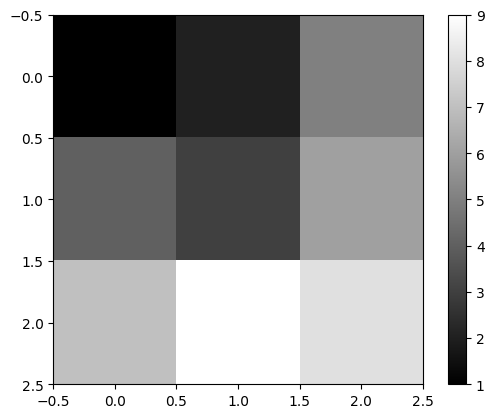

In [5]:
#### Part (a)
# Load and plot image
img1 = io.loadmat("Data/IM1.mat").get("IM1")
plt.figure(1)
plt.imshow(img1, cmap="gray")
plt.colorbar()
plt.show()


Peforming nearest neighbor interpolation...
Progress: (  3,  3) out of (3, 3)
Performing bilinear interpolation...
Progress: (  3,  3) out of (3, 3)	rank(A)=4
Performing bicubic interpolation...
Image must have shape of at least (4,4). Padding image to minimum size.
Progress: (  7,  7) out of (7, 7)	rank(A)=15


<Figure size 640x480 with 0 Axes>

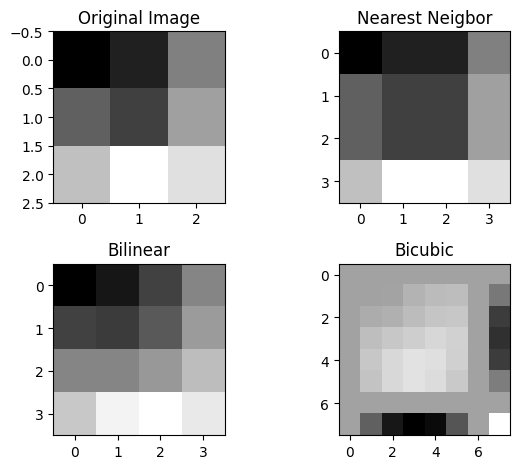

In [6]:

#### Part (b)
# Zoom and interpolate images
nn_zoom = nearest_neighbor(img1, 1.5)
bl_zoom = bilinear(img1, 1.5)
bc_zoom = bicubic(img1, 1.5)

plt.tight_layout()

# Plot images
fig,ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].imshow(img1, cmap="gray")
ax[0,1].imshow(nn_zoom, cmap="gray")
ax[1,0].imshow(bl_zoom, cmap="gray")
ax[1,1].imshow(bc_zoom, cmap="gray")

ax[0,0].set_title("Original Image")
ax[0,1].set_title("Nearest Neigbor")
ax[1,0].set_title("Bilinear")
ax[1,1].set_title("Bicubic")

plt.tight_layout()

Performing bicubic interpolation...
Progress: (224,224) out of (224, 224)	rank(A)=10rank(A)=12rank(A)=11rank(A)=13rank(A)=12rank(A)=16rank(A)=13rank(A)=14rank(A)=12rank(A)=14rank(A)=13rank(A)=14rank(A)=13rank(A)=14rank(A)=12rank(A)=14rank(A)=13rank(A)=15rank(A)=13rank(A)=14rank(A)=12rank(A)=15rank(A)=13rank(A)=15rank(A)=13rank(A)=14rank(A)=12rank(A)=15rank(A)=12rank(A)=12rank(A)=14rank(A)=12rank(A)=16rank(A)=12rank(A)=15rank(A)=12rank(A)=14rank(A)=15rank(A)=12rank(A)=16rank(A)=12rank(A)=14rank(A)=12rank(A)=12rank(A)=15rank(A)=12rank(A)=13rank(A)=14rank(A)=12rank(A)=12rank(A)=13rank(A)=12rank(A)=13rank(A)=12rank(A)=13rank(A)=12rank(A)=13rank(A)=12rank(A)=13rank(A)=12rank(A)=14rank(A)=12rank(A)=12rank(A)=13rank(A)=12rank(A)=13rank(A)=12rank(A)=13rank(A)=12rank(A)=13rank(A)=12rank(A)=14rank(A)=12rank(A)=13rank(A)=12rank(A)=11rank(A)=12rank(A)=11rank(A)=11rank(A)=13rank(A)=10rank(A)=13rank(A)=11rank(A)=13rank(A)=11rank(A)=13rank(A)=11rank(A)=14rank(A)=12rank(A)=11rank(A)=13rank(A)=11rank(A

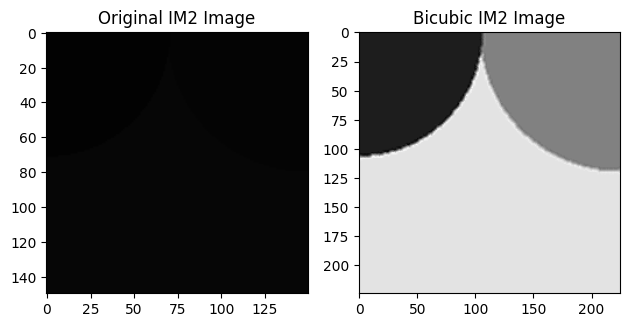

In [7]:

#### Part (c)
img2 = io.loadmat("Data/IM2.mat").get("IM2")
zoomed_2 = bicubic(img2, 1.5)

fig2,ax2 = plt.subplots(nrows=1, ncols=2)
ax2[0].imshow(img2, cmap="gray", vmin=0, vmax=255)
ax2[1].imshow(zoomed_2, cmap="gray")

ax2[0].set_title('Original IM2 Image')
ax2[1].set_title('Bicubic IM2 Image')


plt.tight_layout()
plt.show()